In [98]:
import sys
import os
sys.path.append('/root/capsule/code/beh_ephys_analysis')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import LinearSegmentedColormap
import pandas as pd
from pynwb import NWBFile, TimeSeries, NWBHDF5IO
from scipy.io import loadmat
from scipy.stats import zscore
import ast
from pathlib import Path
import glob
import json
import seaborn as sns
from PyPDF2 import PdfMerger
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import re
from utils.beh_functions import session_dirs, parseSessionID, load_model_dv, makeSessionDF, get_session_tbl, get_unit_tbl, get_history_from_nwb
from utils.ephys_functions import*
import pickle
import scipy.stats as stats
import spikeinterface as si
import shutil
from sklearn.metrics import roc_auc_score, roc_curve
%matplotlib inline

In [99]:
# load all units data
with open(os.path.join('/root/capsule/scratch/combined/combine_unit_tbl', 'combined_unit_tbl.pkl'), 'rb') as f:
    combined_tagged_units = pickle.load(f)

In [100]:
beh_criteria_name = 'beh_all'
wf_criteria_name = 'waveform_all'
# Load the constraints for behavior and waveform criteria
with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{beh_criteria_name}.json'), 'r') as f:
    constraints_beh = json.load(f)

with open(os.path.join('/root/capsule/scratch/combined/metrics', f'{wf_criteria_name}.json'), 'r') as f:
    constraints_wf = json.load(f)
# load pre-computed behavior and waveform metrics
beh_metrics = pd.read_csv(os.path.join('/root/capsule/scratch/combined/beh_plots', beh_criteria_name, f'model_combined_{beh_criteria_name}.csv'))
wf_metrics = pd.read_csv(os.path.join('/root/capsule/scratch/combined/wf_plots', wf_criteria_name, 'wf_features.csv'))
wf_metrics.rename(columns={'unit_id': 'unit'}, inplace=True)

beh_wf_folder = os.path.join('/root/capsule/scratch/combined/beh_wf_plots', beh_criteria_name+wf_criteria_name+'.json')
if not os.path.exists(beh_wf_folder):
    os.makedirs(beh_wf_folder)

In [101]:
combined_metrics_both = beh_metrics.merge(wf_metrics, on=['unit', 'session'], how='inner')
combined_metrics_both = combined_metrics_both.merge(combined_tagged_units, on=['unit', 'session'], how='inner')
wf_metrics = wf_metrics.merge(combined_tagged_units, on=['unit', 'session'], how='left', suffixes=('', '_right'))
wf_mertics = wf_metrics[[col for col in wf_metrics.columns if not col.endswith('_right')]]
# wf_metrics = wf_metrics.merge(beh_metrics, on=['unit', 'session'], how='left', suffixes=('', '_right'))
beh_metrics = beh_metrics.merge(combined_tagged_units, on=['unit', 'session'], how='left', suffixes=('', '_right'))
beh_metrics = beh_metrics[[col for col in beh_metrics.columns if not col.endswith('_right')]]

In [102]:
wf_metrics.columns.sort_values()

Index(['amp', 'amp_right', 'anti', 'anti_resp', 'bottom', 'corr', 'eu',
       'gmm_label', 'half_w', 'in_df', 'isi_violations', 'lat_max_p',
       'opto_tagged', 'opto_tagging_post', 'opto_tagging_pre', 'p_max', 'pc1',
       'pc2', 'peak', 'peak_right', 'post_half', 'post_slope', 'post_space',
       'pre_half', 'pre_slope', 'pre_space', 'probe', 'probe_right', 'proj',
       'qc_pass', 'rec_side', 'score', 'session', 'symmetry_half',
       'symmetry_half_div', 'symmetry_inte', 'symmetry_inte_div',
       'symmetry_slope', 'symmetry_slope_div', 'top', 'trial_count',
       'trough_post_ratio_1D', 'trough_pre_ratio_1D', 'trough_w', 'unit', 'wf',
       'wf_2d', 'x_ccf', 'y_ccf', 'y_loc', 'y_loc_right', 'z_ccf'],
      dtype='object')

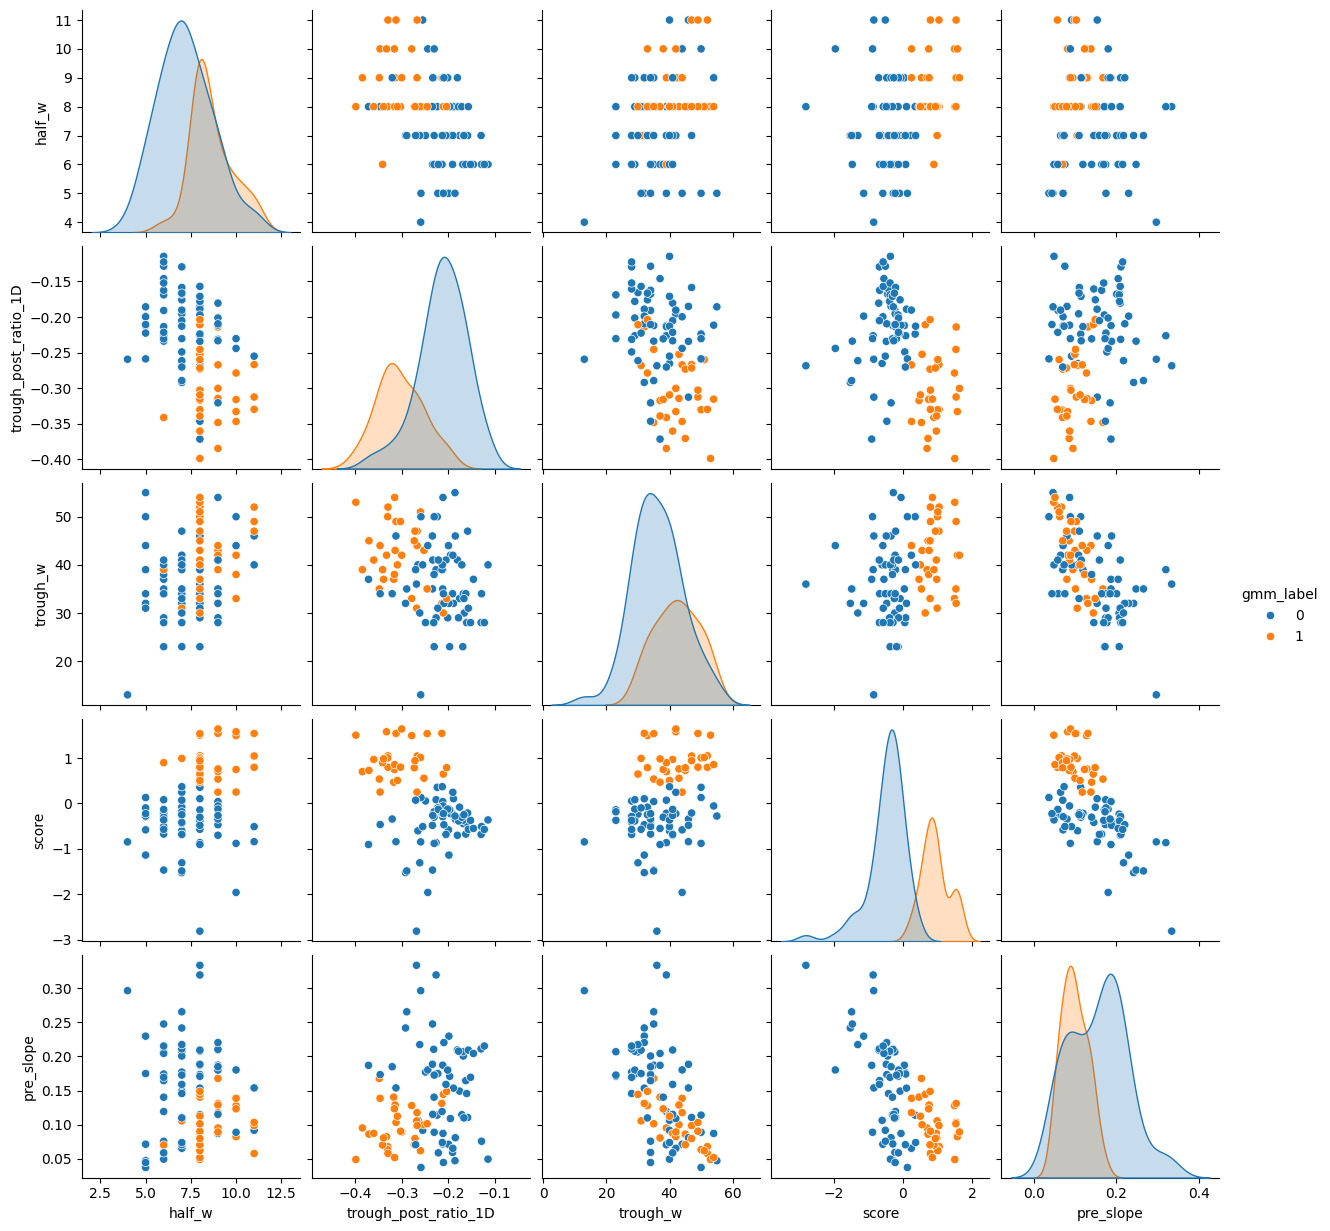

In [73]:
# plot scatter plot in feature space
sns.pairplot(wf_metrics[['half_w', 'trough_post_ratio_1D', 'trough_w', 'score', 'gmm_label', 'pre_slope']], vars=['half_w', 'trough_post_ratio_1D', 'trough_w', 'score', 'pre_slope'], hue='gmm_label', corner=False)

In [74]:
beh_metrics.columns.sort_values()

Index(['Qchosen_T', 'Qchosen_coef', 'Qchosen_p', 'amp', 'anti', 'corr', 'eu',
       'in_df', 'ipsi_T', 'ipsi_coef', 'ipsi_p', 'isi_violations', 'lat_max_p',
       'opto_tagged', 'opto_tagging_post', 'opto_tagging_pre',
       'outcome:ipsi_T', 'outcome:ipsi_coef', 'outcome:ipsi_p', 'outcome_T',
       'outcome_coef', 'outcome_p', 'p_max', 'peak', 'probe', 'qc_pass',
       'rec_side', 'session', 'trial_count', 'unit', 'wf', 'wf_2d', 'y_loc'],
      dtype='object')

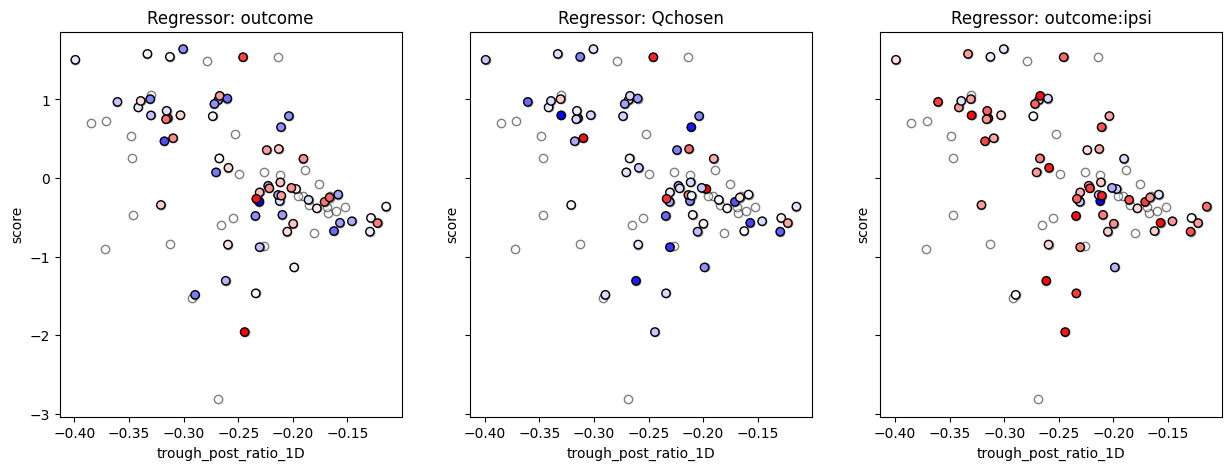

In [84]:
x_feature = 'trough_post_ratio_1D'
y_feature = 'score'
regressors = ['outcome', 'Qchosen', 'outcome:ipsi']
p_threshold = 1
fig, axes = plt.subplots(1, len(regressors), figsize=(15, 5), sharey=True, sharex=True)
x_values_all = wf_metrics[x_feature].values
y_values_all = wf_metrics[y_feature].values
x_values_beh = combined_metrics_both[x_feature].values
y_values_beh = combined_metrics_both[y_feature].values
for i, regressor in enumerate(regressors):
    ax = axes[i]
    custom_cmap = LinearSegmentedColormap.from_list(
        'blue_white_red',
        [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
    )
    p_curr=combined_metrics_both[regressor+'_p'].values
    color_reg = combined_metrics_both[regressor+'_T'].values
    mask = p_curr < p_threshold
    norm = Normalize(vmin=-10, vmax=10)
    ax.scatter(
        x_values_all,
        y_values_all,
        alpha=0.5,
        c='white',
        edgecolors='k'
    )
    color_reg = 0.5 + 0.5 * color_reg/np.max(np.abs(color_reg))  # Normalize color values
    ax.scatter(
        x_values_beh[mask],
        y_values_beh[mask],
        alpha=1,
        c=color_reg[mask],
        cmap=custom_cmap,
        # norm=norm,
        edgecolors='k' 
    )
    ax.set_xlabel(x_feature)
    ax.set_ylabel(y_feature)
    ax.set_title(f'Regressor: {regressor}')

In [97]:
len(combined_metrics_both)

65

In [85]:
combined_metrics_both.columns.sort_values()

Index(['Qchosen_T', 'Qchosen_coef', 'Qchosen_p', 'amp_x', 'amp_y', 'anti',
       'corr', 'eu', 'gmm_label', 'half_w', 'in_df', 'ipsi_T', 'ipsi_coef',
       'ipsi_p', 'isi_violations', 'lat_max_p', 'opto_tagged',
       'opto_tagging_post', 'opto_tagging_pre', 'outcome:ipsi_T',
       'outcome:ipsi_coef', 'outcome:ipsi_p', 'outcome_T', 'outcome_coef',
       'outcome_p', 'p_max', 'pc1', 'pc2', 'peak_x', 'peak_y', 'post_half',
       'post_slope', 'post_space', 'pre_half', 'pre_slope', 'pre_space',
       'probe_x', 'probe_y', 'qc_pass', 'rec_side', 'score', 'session',
       'symmetry_half', 'symmetry_half_div', 'symmetry_inte',
       'symmetry_inte_div', 'symmetry_slope', 'symmetry_slope_div',
       'trial_count', 'trough_post_ratio_1D', 'trough_pre_ratio_1D',
       'trough_w', 'unit', 'wf', 'wf_2d', 'y_loc_x', 'y_loc_y'],
      dtype='object')

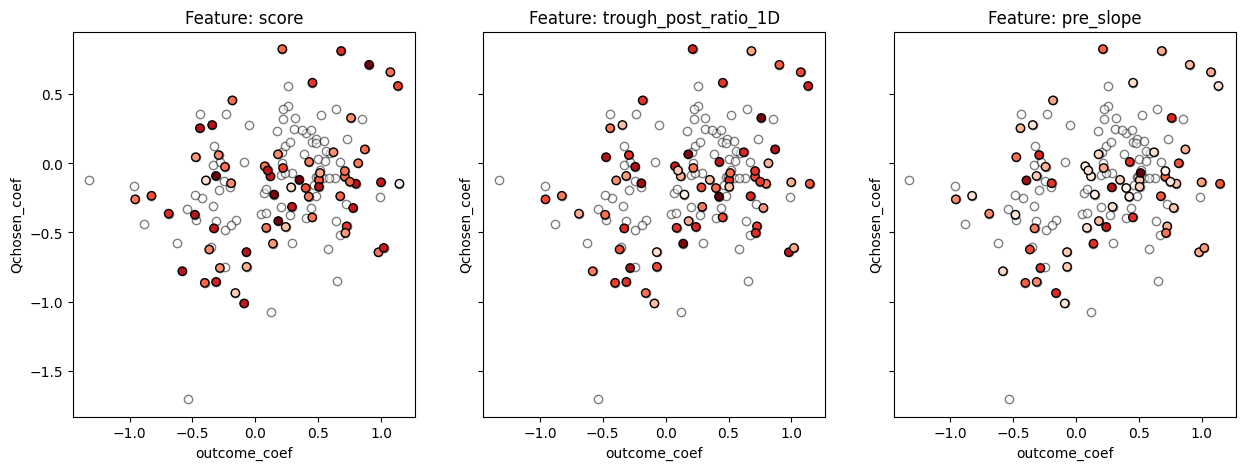

In [90]:
x_beh = 'outcome_coef'
y_beh = 'Qchosen_coef'
features = ['score', 'trough_post_ratio_1D', 'pre_slope']
fig, axes = plt.subplots(1, len(features), figsize=(15, 5), sharey=True, sharex=True)
x_values_all = beh_metrics[x_beh].values
y_values_all = beh_metrics[y_beh].values
x_values_feature = combined_metrics_both[x_beh].values
y_values_feature = combined_metrics_both[y_beh].values
custom_cmap = LinearSegmentedColormap.from_list(
    'blue_white_red',
    [(0.0, 'blue'), (0.5, 'white'), (1.0, 'red')]
)
for i, feature in enumerate(features):
    ax = axes[i]

    color_feature = combined_metrics_both[feature].values
    # mask = p_curr < p_threshold
    norm = Normalize(vmin=0, vmax=1)
    ax.scatter(
        x_values_all,
        y_values_all,
        alpha=0.5,
        c='white',
        edgecolors='k'
    )
    ax.scatter(
        x_values_feature,
        y_values_feature,
        alpha=1,
        c=color_feature,
        # cmap=custom_cmap,
        # norm=norm,
        cmap='Reds',
        edgecolors='k'
    )
    ax.set_xlabel(x_beh)
    ax.set_ylabel(y_beh)
    ax.set_title(f'Feature: {feature}')


Text(0.5, 0.98, 'Outcome and Qchosen coefficients')

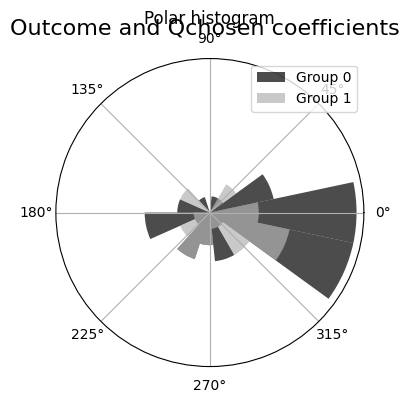

In [96]:
# polar histo
x_reg = 'outcome'
y_reg = 'Qchosen'
thresh = 1
curr_coefs_x = combined_metrics_both[x_reg+'_coef'].values
curr_coefs_y = combined_metrics_both[y_reg+'_coef'].values
curr_p_x = combined_metrics_both[x_reg+'_p'].values
curr_p_y = combined_metrics_both[y_reg+'_p'].values
group_ids = combined_metrics_both['gmm_label'].values
colors = [[0, 0, 0], [0.7, 0.7, 0.7]]
all_vec = np.column_stack((curr_coefs_x, curr_coefs_y))  # combine the coefficients for the reward outcome and Qchosen
edges = np.linspace(-np.pi, np.pi, 4*4)
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111, polar=True)
# Convert Cartesian coordinates to polar coordinates
for group_ind, group_id in enumerate(np.unique(group_ids)):
    all_vec_curr = all_vec[(group_ids == group_id) & (curr_p_x < thresh)]
    theta, rho = np.arctan2(all_vec_curr[:, 1], all_vec_curr[:, 0]), np.hypot(all_vec_curr[:, 1], all_vec_curr[:, 0])
    ax.hist(theta, bins=edges, color=colors[group_ind], alpha=0.7, edgecolor='none', density=False, label=f'Group {group_id}')
ax.set_yticks([])
ax.set_title('Polar histogram')
ax.legend()
plt.suptitle('Outcome and Qchosen coefficients', fontsize=16)
# plt.savefig(os.path.join(beh_folder, f'Summary_outcome_Qchosen_coeffs_{criteria_name}.pdf'), bbox_inches='tight')